# ML – Домашнее задание 6

### Дизайн эксперимента

**Дедлайн:** 23:59, 19 апреля

### **Вам необходимо:**  
Провести дизайн эксперимента на ранее использованных вами датасетах (на ваше усмотрение).  
Для этого можете использовать библиотеку [ambrosia](https://github.com/MobileTeleSystems/Ambrosia) для упрощения процесса построения дизайна.

### **В работе необходимо:**

- сформулировать продуктовую гипотезу касательно метрики  
- провести дизайн эксперимента  
- описать как вы будете проводить эксперимент (по результатам дизайна) с точки зрения продуктовой ценности  
- описать как вы будете в дальнейшем принимать решения  

### **Формат сдачи:**  
HTML/PDF-версия jupyter-ноутбука, с датасетом и выполненным заданием

### **Для получения зачета необходимо:**

**Зачет на 4:**  
Проведен стандартный дизайн, прописаны выводы и интерпретация результатов

**Зачет на 5:**  
Проведен дизайн и аналитическим, и эмпирическим методом, проведена сравнительная оценка результатов. Подготовлены выводы и интерпретация результатов

### **ВАЖНО! Ссылки должны быть рабочие и с открытым доступом для скачивания.**

Желаем удачи!


#### Библиотеки

In [3]:
# AMBROSIA

from ambrosia.designer import Designer
from ambrosia.splitter import Splitter
from ambrosia.tester import Tester
from ambrosia.preprocessing import AggregatePreprocessor

# OTHERS

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as sts
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# Настройка стиля
plt.style.use('classic')
palette = sns.color_palette("husl", 8)
%matplotlib inline

# Для изображения
from IPython.display import Image

### Подготовка данных
#### **RecSys Course Competition**

[Link](https://ods.ai/competitions/competition-recsys-21)

Вам предоставлены данные из приложения МТС Kion по взаимодействиям пользователей с контентом за период 6 месяцев.
В отдельных файлах есть:

- факты просмотра контента пользователями
- описание контента
- описание пользователей

**interactions.csv**
В данном файле содержится информация о взаимодействиях пользователей с контентом:

`user_id` - ID пользователя

`item_id` - ID контента

`last_watch_dt` - Дата последнего просмотра

`total_dur` - Общая продолжительность всех просмотров данного контента в секундах

`content_type` - Тип контента (фильм, сериал)

In [5]:
df_interactions = pd.read_csv('interactions.csv')
df_items = pd.read_csv('items.csv')
df_users = pd.read_csv('users.csv')

In [6]:
df_interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [7]:
df_users = df_users.drop(['sex', 'kids_flg'], axis=1)
df_items = df_items.drop(['title', 'title_orig', 'genres', 'countries', 'for_kids', 'age_rating', 'studios', 
                                 'directors', 'actors', 'keywords', 'description', 'release_year', 'content_type'], axis=1)

df_merged = df_interactions.merge(df_items, how='left', on='item_id')

df_merged = df_merged.drop(['item_id'], axis=1)
df_merged = df_merged.dropna()
df = df_merged
df.head()

,user_id,last_watch_dt,total_dur,watched_pct
0,176549,2021-05-11,4250,72.0
1,699317,2021-05-29,8317,100.0
2,656683,2021-05-09,10,0.0
3,864613,2021-07-05,14483,100.0
4,964868,2021-04-30,6725,100.0


In [8]:
df['last_watch_dt'] = pd.to_datetime(df['last_watch_dt'])

df = df.merge(df_users, how='left', on='user_id')
df.head()

,user_id,last_watch_dt,total_dur,watched_pct,age,income
0,176549,2021-05-11,4250,72.0,age_35_44,income_40_60
1,699317,2021-05-29,8317,100.0,age_35_44,income_40_60
2,656683,2021-05-09,10,0.0,age_25_34,income_60_90
3,864613,2021-07-05,14483,100.0,age_65_inf,income_20_40
4,964868,2021-04-30,6725,100.0,age_25_34,income_20_40


In [9]:
# dropna
df = df.dropna()

# Проверю пропуски
print(pd.isnull(df).sum())

# Проверка типов данных
print(df.dtypes)

user_id          0
last_watch_dt    0
total_dur        0
watched_pct      0
age              0
income           0
dtype: int64
user_id                   int64
last_watch_dt    datetime64[ns]
total_dur                 int64
watched_pct             float64
age                      object
income                   object
dtype: object


#### Агрегация метрик в разрезе 1 недели

In [11]:
transformer = AggregatePreprocessor()

In [12]:
df = transformer.fit_transform(dataframe=df,
                               groupby_columns='user_id',
                               agg_params={
                                   'total_dur': 'sum', # сумма времени просмотра по пользователю
                                   'watched_pct': 'mean', # среднее от процента по всем типам просматриваемого контента
                                   'age': 'simple',
                                   'income': 'simple',
                                   'last_watch_dt': 'max' # последняя дата активности
                               })

In [13]:
print(df['user_id'].nunique())
print(df['total_dur'].mean()) # среднее по метрике 45676.08319298049
print(df['watched_pct'].mean()) # среднее по метрике 38.38156650367712

733271
45676.08319298049
38.38156650367712


In [14]:
df.head()

,user_id,total_dur,watched_pct,age,income,last_watch_dt
0,0,852,0.833333,age_65_inf,income_20_40,2021-07-20
1,1,21172,53.000000,age_25_34,income_20_40,2021-08-16
2,2,268806,83.877551,age_25_34,income_40_60,2021-06-26
3,4,5813,48.500000,age_25_34,income_40_60,2021-07-02
4,7,672,17.000000,age_45_54,income_40_60,2021-04-07


## Пайплайн A/B теста
#### Напомню классический пайплайн A/B тестирования

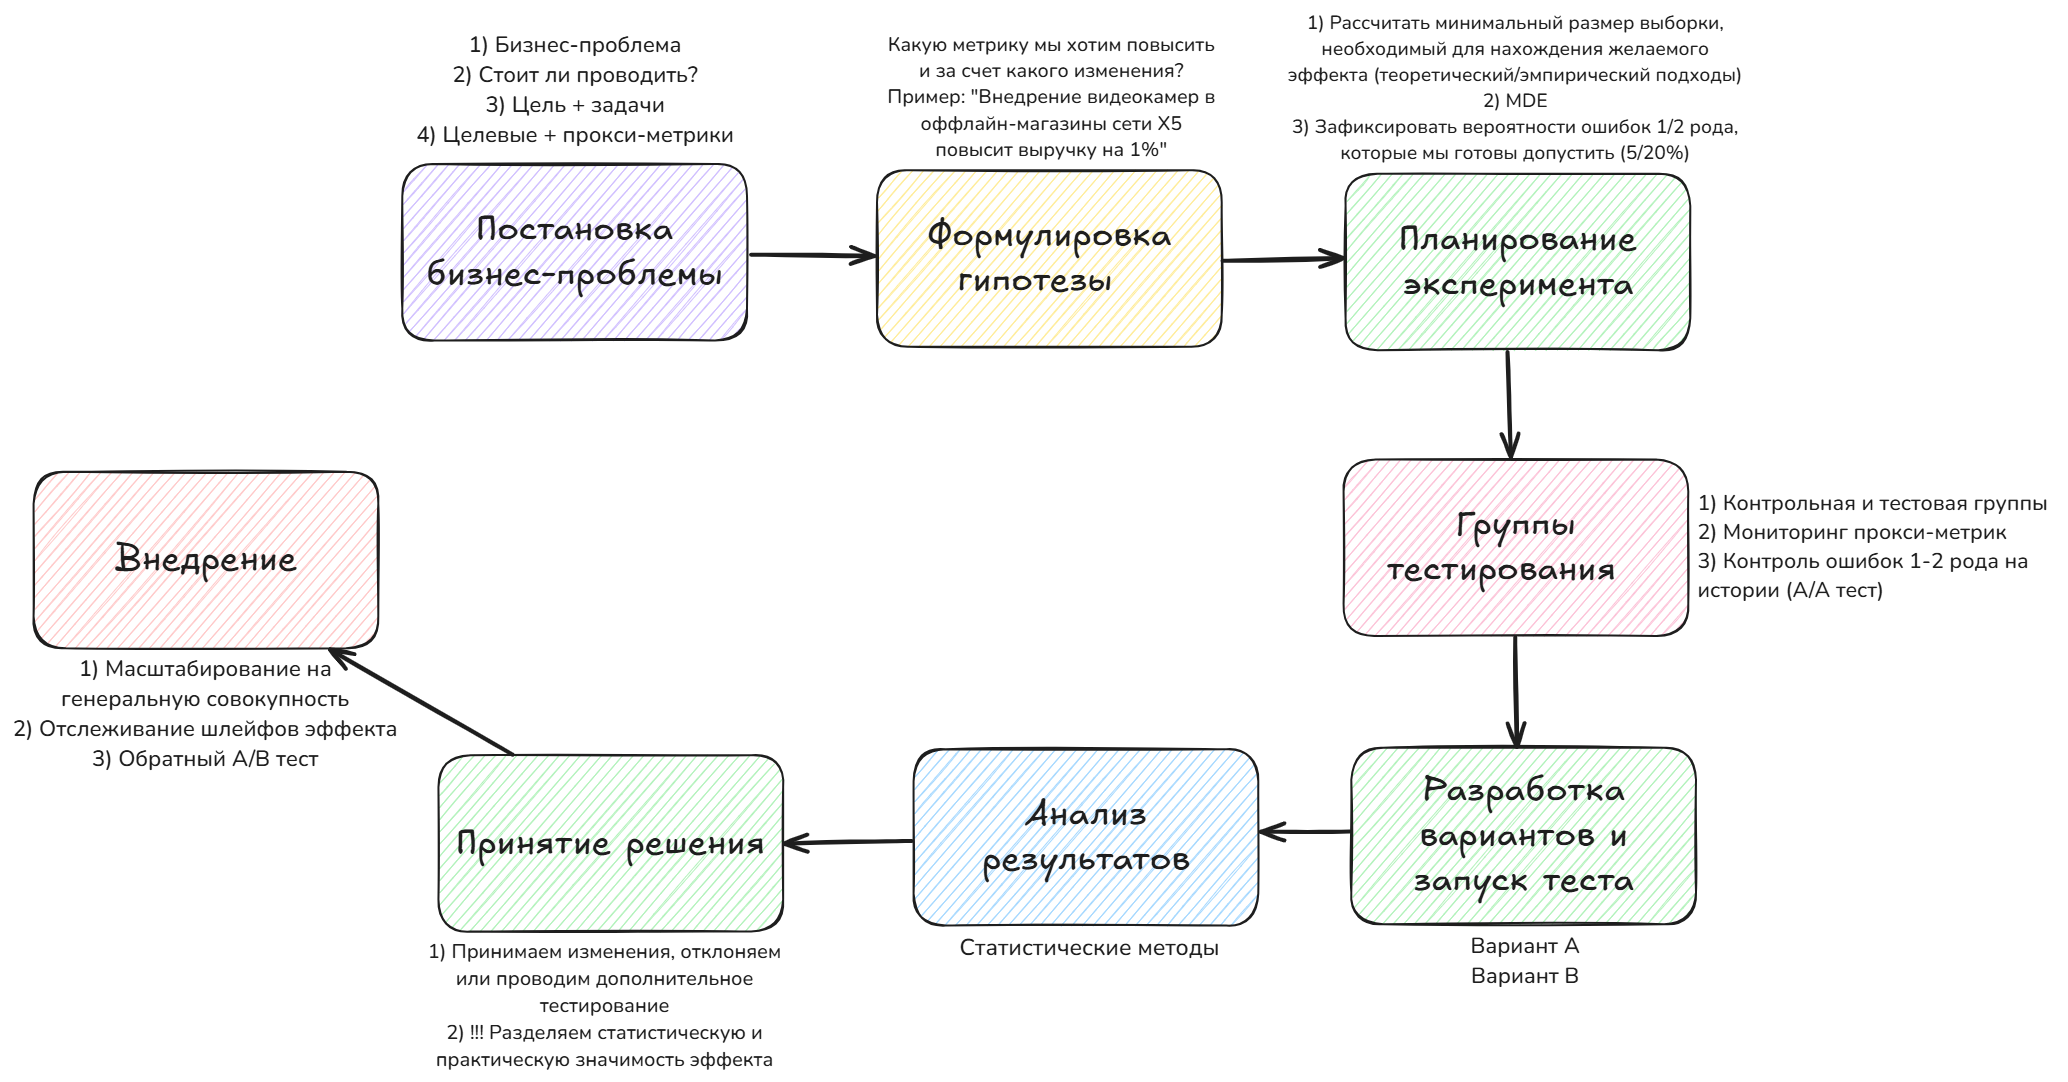

In [16]:
Image("AB_testing_pipeline.png")

#### Пару слов о метриках

Пользователи были сагрегировны по в первой попавшейся возрастной группе и доходу (`parameter simple`)

Напомню, что `total_dur` - общая продолжительность всех просмотров данного контента в секундах; я взял сумму продолжительности просмотра контента всех типов для 1 пользователя (предпосылка о независимости неаблюдений);

`watched_pct` - процент просмотренного контента; я взял средний процент просмотра контента всех типов для 1 пользователя (предпосылка о независимости неаблюдений).

#### Пару слов о группах

Не буду делать фокус на анализе изменений в разрере различных групп (например, проверка нововведения конкретно для возрастной группы 25-34 или же с доходом 20-40). Исследование будет сфокусировано на глобальных изменениях в целевых метриках.

## Дизайн эксперимента

### Постановка бизнес-проблемы

**Бизнес-проблема**: низкая вовлеченность пользователей в просмотр рекомендуемого им контента.

**Стоит ли проводить эксперимент?** Стоит, так как с потенциальным повышением вовлеченности последует ряд финансовых выгод.

**Цель эксперимента**: увеличить вовлеченность пользователей в просмотр рекомендуемого им контента.

**Задачи эксперимента**: 

- Выявить потенциальные проблемы и их причины для вовлеченности (не уделяем данному аспекту внимание в ноутбуке);
- Разработать и внедрить альтернативный вариант некоторой рекомендательной системы (не уделяем данному аспекту внимание в ноутбуке);
- Подготовить метрики для оценки эффективности нового процесса.

**Целевая метрика эксперимента**:
`total_dur` - общая продолжительность всех просмотров данного контента в секундах для пользователя.

**Прокси-метрика эксперимента**:
`watched_pct` - средний процент просмотра данного контента для пользователя.

### Формулировка продуктовой гипотезы

Напомню, что среднее по метрике `total_dur` на данный момент -  45676.083 секунды. Хотим увидеть 5% эффект на целевой метрике, то есть, поднять средний показатель по метрике до условных 47959.88715 секунд. Сформулируем релевантную гипотезу.

#### "Внедрение новой рекомендательной системы повысит вовлеченность пользователей в просмотр предлагаемого им контента на 10%"

$H_0$ - новая рекомендательная система НЕ оказывает статистически значимого влияния на метрику `total_dur`

$H_1$ - новая рекомендательная система оказывает статистически значимое влияние на метрику `total_dur`

### Планирование эксперимента

#### Вероятности ошибок 1-2 рода

В экспериментах важную роль играют ошибки 1 и 2 рода, так как в зависимости от их допустимых значений будет изменяться дизайн A/B теста. Напомним определения:  

- **Ошибка первого рода** — отвергаем верную нулевую гипотезу. Нашли эффект там, где его нет  
- **Ошибка второго рода** — принимаем нулевую гипотезу, когда эффект существует. Пропустили эффект
$$\large
P\left( \left| \bar{Y} - \bar{X} \right| \geq \varepsilon \mid \mu_y - \mu_x = 0 \right) = \alpha
$$
$$\large
P\left( \bar{Y} - \bar{X} < \varepsilon \mid \mu_y = \mu_x (1 + \delta) \right) = \beta
$$

> **В данном эксперименте используем индустриальный стандарт в $\alpha = 0.05$ и $\beta = 0.2$**

### Минимальный размер выборки

Класс Designer - это основной инструмент Ambrosia для расчета экспериментальных параметров.

In [27]:
designer = Designer(dataframe=df, metrics='total_dur')

### Теоретический дизайн (подход)

Теперь мы рассчитаем параметры эксперимента, используя теоретический подход и сетку других известных параметров.


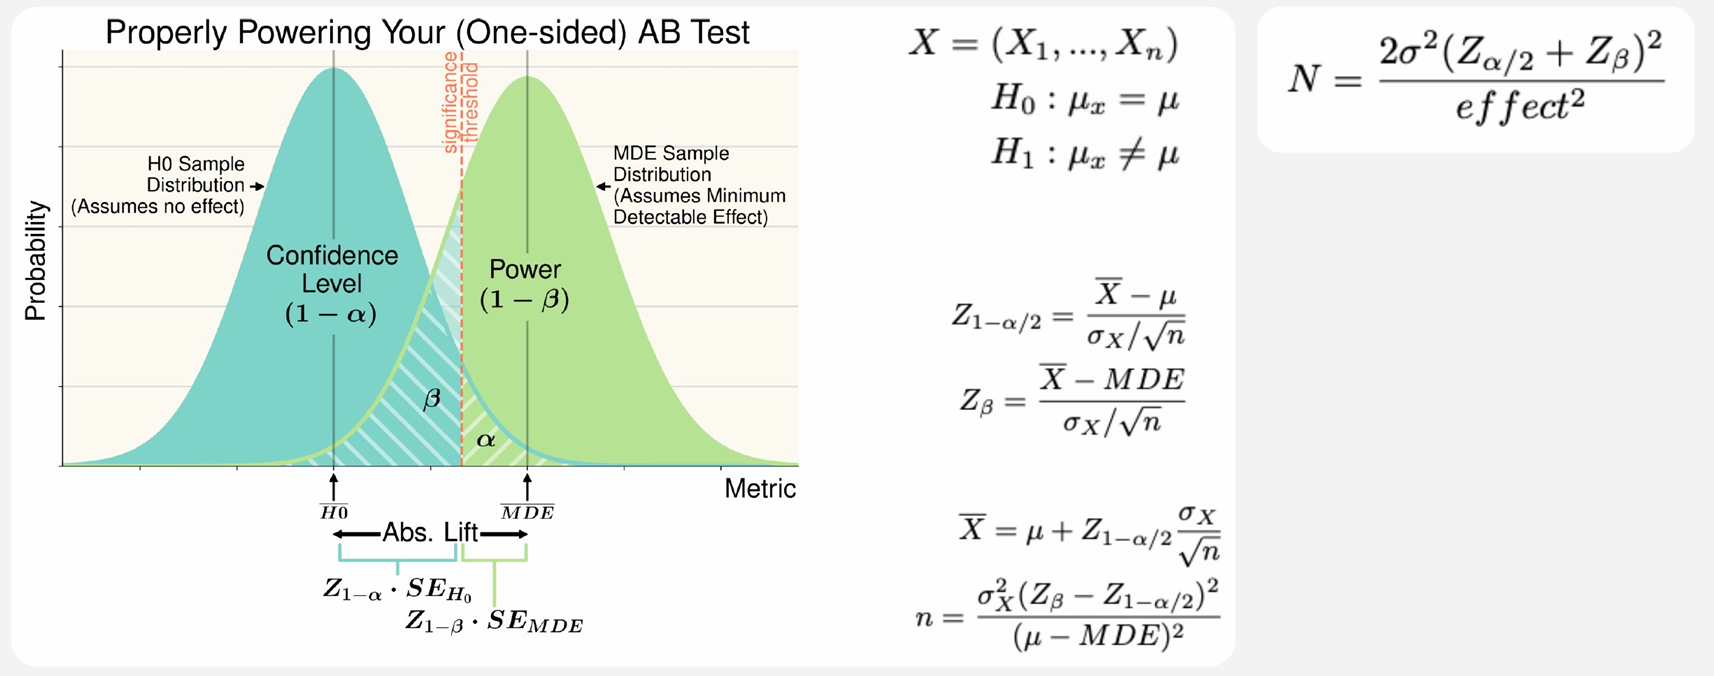

In [148]:
Image("theoretical_appoach.png")

#### Оценим глобально

In [30]:
### Set parameters grid
effects = [1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.15, 1.2]  # MDE in percents
sizes = [5000, 10000, 15000, 30000, 50000, 80000, 100000, 150000]  # Size of each group
first_type_errors = [0.01, 0.05]
second_type_errors = [0.1, 0.2]

In [31]:
designer.run(to_design='effect',
             method='theory',
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes)

"Errors ($\alpha$, $\beta$)",(0.01; 0.1),(0.01; 0.2),(0.05; 0.1),(0.05; 0.2)
Group sizes,,,,
5000,27.1%,24.0%,22.8%,19.7%
10000,19.2%,17.0%,16.1%,13.9%
15000,15.7%,13.9%,13.2%,11.4%
30000,11.1%,9.8%,9.3%,8.0%
50000,8.6%,7.6%,7.2%,6.2%
80000,6.8%,6.0%,5.7%,4.9%
100000,6.1%,5.4%,5.1%,4.4%
150000,5.0%,4.4%,4.2%,3.6%


In [32]:
designer.run(to_design='power', 
             method='theory', 
             effects=effects, 
             sizes=sizes)

Group sizes     5000   10000  15000   30000   50000   80000   100000  150000
$\alpha$ Effect                                                             
0.05     1.0%     5.2%   5.5%   5.7%    6.4%    7.3%    8.8%    9.7%   12.2%
         2.0%     5.9%   6.9%   7.8%   10.7%   14.7%   20.6%   24.6%   34.4%
         3.0%     7.1%   9.3%  11.5%   18.1%   27.1%   40.0%   47.9%   64.7%
         4.0%     8.8%  12.7%  16.6%   28.6%   43.6%   62.4%   72.0%   87.6%
         5.0%    11.0%  17.1%  23.4%   41.4%   61.4%   81.2%   88.9%   97.3%
         10.0%   29.6%  52.0%  69.3%   93.6%   99.4%  100.0%  100.0%  100.0%
         15.0%   56.9%  85.5%  95.9%   99.9%  100.0%  100.0%    nan%    nan%
         20.0%   81.2%  98.0%  99.8%  100.0%    nan%  100.0%  100.0%    nan%

In [33]:
designer.set_first_errors(first_type_errors)
designer.set_second_errors(second_type_errors)

#### Оценим с конкретно интересующими нас уровнями ошибок и эффектом

In [35]:
### Set parameters grid
effects = [1.05]  # MDE in percents
first_type_errors = [0.05]
second_type_errors = [0.2]

In [36]:
designer.run(to_design='size', 
             method='theory', 
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             effects=effects)

"Errors ($\alpha$, $\beta$)",(0.05; 0.2)
Effect,
5.0%,77629


#### **Для нашего эксперимента достаточно примерно 77629 объектов в каждой экспериментальной группе**

#### Посмотрим на распределение целевой метрики

<Axes: ylabel='Density'>

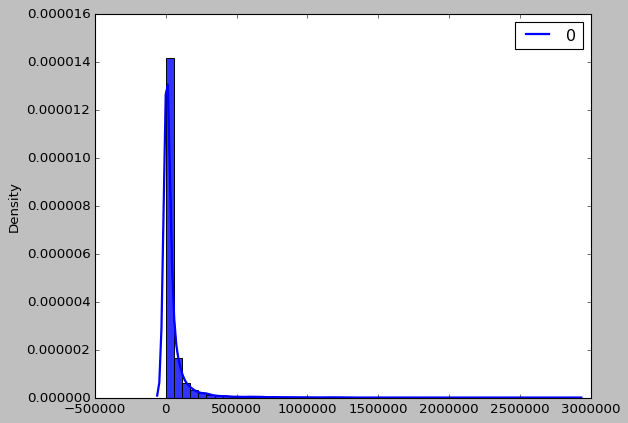

In [103]:
x_value = np.random.choice(df['total_dur'], size=10000, replace=True)
x_value = pd.DataFrame(x_value)
sns.histplot(data=x_value,
             bins=50, 
             kde=True, 
             color="pink", 
             edgecolor="black", 
             alpha=0.8, 
             stat="density"
            )

sns.kdeplot(data=x_value,
            color="orange", 
            linewidth=2)

### Эмпирический дизайн (подход)

**Справка:**

Теперь мы изменим метод проектирования на эмпирический и рассчитаем размеры групп, проведя множество псевдо-A/B тестов на исторических данных.

Чтобы ограничить вычислительные затраты, мы установим для параметра bs_samples низкое значение. 
Этот параметр определяет, сколько псевдо-A/B тестов мы проведем для оценки одного значения параметра, а высокие значения (желательно использовать как минимум >1000) позволят получить более точную оценку параметров.

В моем случае использую менее 1000 итераций, так как при большем числе слишком тяжело прогрузить результаты.

В качестве статистического критерия используем критерий Уилкоксона-Манна-Уитни (`MW`) для двух выборок.

In [39]:
designer.run(to_design='size',
             method='empiric',
             effects=effects,
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             criterion='mw',
             bs_samples=100,
             n_jobs=1)

Group sizes calculation:   0%|          | 0/1 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.05, 0.2)"
Effect,
5.0%,32016


Теперь попробуем получить результаты с помощью стандартного t-теста:

In [45]:
designer.run(to_design='size',
             method='empiric',
             effects=effects,
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes,
             criterion='ttest',
             bs_samples=100,
             n_jobs=1)

Group sizes calculation:   0%|          | 0/1 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.05, 0.2)"
Effect,
5.0%,66424


Сделаем оценку через бутстрап. Использую только 20 итераций, так как при 100 решение не получалось за более, чем 15 минут, а при распараллеливании память не вытягивает.

In [128]:
designer.run(to_design='size',
             method='empiric',
             effects=effects,
             first_type_errors=first_type_errors,
             second_type_errors=second_type_errors,
             sizes=sizes,
             criterion='bootstrap',
             bs_samples=20,
             n_jobs=1)

Group sizes calculation:   0%|          | 0/1 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.05, 0.2)"
Effect,
5.0%,70860


#### Сводная таблица

| Метод               | Критерий        | Уровень ошибок (α; β) | Желаемый эффект, MDE (%) | Размер группы |
|---------------------|------------------|------------------------|-------------|----------------|
| Теоретический       | -                | (0.05; 0.2)            | 5.0%        | 77,629         |
| Эмпирический        | Mann–Whitney     | (0.05; 0.2)            | 5.0%        | 32,016         |
| Эмпирический        | t-test           | (0.05; 0.2)            | 5.0%        | 66,424         |
| Эмпирический (20 итераций) | Bootstrap        | (0.05; 0.2)            | 5.0%        | 70,860         |


#### Выводы:

- Можно отметить, что результаты тестирования с помощью критерия `MW` значительно отличаются как от теоретического подхода, так и эмпирик, полученных с помощьюt-теста и бутстрапа;
- Так как бутстрап на должном числе итераций провести не удалось, тем не менее, было отмечено, что по мере увеличения числа итераций, растет и необходимое число наблюдений для группы (пробовал для 10 итераций перед запуском для 20 итераций, разница несколько тыс.);
- Есть предположение, что эмпирически полученное число наблюдений стремится к теоретическому числу наблюдений;
- Так как распределения достаточно сложное, считаю, что стоит ориентироваться именно на результаты бутстрапа, а если они стремятся к теоретической оценке - то возьму как раз её.

### Группы тестирования: сплит по группам

Используем стандартный батч-сплит.
Для детерминированной оценки результата используем hash-split.

Будем использовать стратификацию для сохранения пропорций страт по переменным `age` и `income`

In [117]:
df['income'].unique()

array(['income_20_40', 'income_40_60', 'income_0_20', 'income_90_150',
       'income_60_90', 'income_150_inf'], dtype=object)

Закодирую доход стандартно с помощью Label Encoder - так как в целом мы не переживаем, что данные по возрастным группам приобретут некий смысл возрастания

In [119]:
income_categories = np.array(['income_20_40', 'income_40_60', 'income_0_20', 'income_90_150',
                              'income_60_90', 'income_150_inf'])

label_encoder = LabelEncoder()
encoded_incomes = label_encoder.fit_transform(income_categories)

df_income = pd.DataFrame({'income': income_categories})

# Кодирование
df_income['income_encoded'] = label_encoder.transform(df_income['income'])

df = df.merge(df_income, how='left', on='income')
df.head()

,user_id,total_dur,watched_pct,age,income,last_watch_dt,income_encoded
0,0,852,0.833333,age_65_inf,income_20_40,2021-07-20,2
1,1,21172,53.000000,age_25_34,income_20_40,2021-08-16,2
2,2,268806,83.877551,age_25_34,income_40_60,2021-06-26,3
3,4,5813,48.500000,age_25_34,income_40_60,2021-07-02,3
4,7,672,17.000000,age_45_54,income_40_60,2021-04-07,3


Класс `splitter`

In [137]:
splitter = Splitter(dataframe=df,
                    strat_columns='age', # стратификация по возрасту
                    fit_columns='income') # метрический метод разбиения

In [139]:
splitted_groups = splitter.run(groups_size=77629, method='hash', salt='exp_322')

C:\Users\smirn\ambrosia-env\lib\site-packages\ambrosia\tools\stratification.py:93: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for values, table in dataframe.groupby(columns):


In [140]:
splitted_groups

,user_id,total_dur,watched_pct,age,income,last_watch_dt,income_encoded,group
27,45,2640,20.000000,age_18_24,income_20_40,2021-06-05,2,A
31,50,58,1.000000,age_18_24,income_40_60,2021-05-19,3,A
53,81,110681,62.294118,age_18_24,income_20_40,2021-06-25,2,A
144,216,5495,11.000000,age_18_24,income_20_40,2021-07-21,2,A
158,238,12978,56.333333,age_18_24,income_40_60,2021-05-31,3,A
...,...,...,...,...,...,...,...,...
79806,119309,15402,13.000000,age_55_64,income_40_60,2021-06-04,3,A
653365,977722,8812,7.000000,age_55_64,income_20_40,2021-06-03,2,B
729602,1092113,74784,55.000000,age_25_34,income_60_90,2021-08-18,4,B
366690,549514,2042,13.000000,age_18_24,income_20_40,2021-05-26,2,B


### Описать как вы будете проводить эксперимент (по результатам дизайна) с точки зрения продуктовой ценности

#### Двухвыборочная гипотеза о среднем для непрерывного случая (**Критерий Уилкоксона-Манна-Уитни**):

А что насчет сдвига в распределениях?

Критерий подходит, так как оценим значимость сдвига распределений, а также критерий работает для независимых выборок.

$$H_0: F_X(x) = F_Y(x)$$
**Пояснение**: наш критерий проверяет гипотезу о равенстве функций распределения двух выборок против альтернативной гипотезы об их сдвиге.; между выборками нет статистически значимого сдвига)

$$H_1: F_X(x) = F_Y(x+m), m\neq0$$
**Пояснение**: между выборками есть статистически значимый сдвиг.

Верхнеуровнево, применяем статистический критерий, смотрим на результаты (p-value, доверительный интервал), делаем соответствующие выводы согласно теории.

#### **Бутстрап**
Тем не менее, учитывая потенциально превосходство **бутстрапа**, я бы склонялся именно к применению данного метода; метод достаточно грубый, но достаточно точно и близко к теоретическому подходу смог оценить размеры выборок; единственное, необходимо решить вопрос с нагрузкой на процессор.

### Описать как вы будете в дальнейшем принимать решения  

Как упомянул выше:
- Оцениваем статистическую значимость результата по p-value и CI;
- Оцениваем эффект;
- Делаем релеватные выводы;
- Если результаты положительные - новая рекомендательная система имеет место быть.

Из дополнительных практик, можно выделить оценку влияния уже на всей генеральной совокупности, ряд мероприятий по отслеживанию шлейфов эффекта, обратное A/B тестирование.

Напомню, что библиотека `ambrosia` также поддерживает класс `Tester`.